In [90]:
import os,sys,string,re
import pandas as pd
import numpy as np
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import matplotlib.pyplot as plt

to_space= '''&,()+'"/'''
trans=string.maketrans(to_space, ' '*len(to_space))
ps = PorterStemmer()

os.chdir('/data/arpit.goel/31_PricePrediction/03.Submissions')
pd.set_option('display.float_format', lambda x: '%.1f' % x)

df_raw_train=pd.read_csv('../input/train.tsv',delimiter='\t')
df_raw_test=pd.read_csv('../input/test.tsv',delimiter='\t')
df_raw_train['log_price']=np.clip(np.log(1+df_raw_train['price']),1,5)

ins=df_raw_train.sample(frac=0.8,random_state=200)
oos=df_raw_train.drop(ins.index)
oot=df_raw_test

In [93]:
def clean_category(x):
    if len(x)==0:
        return ''
    x=re.sub('/',' ',x)
    x=re.sub(chr(195),'e',x)
    x=re.sub(chr(169),'',x)
    x=x.translate(trans)
    x=re.sub(' +',' ',x)
    x=x.lower()
    x=' '.join(list(set(map(ps.stem,x.split(' ')))))
    x=re.sub('(\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)', '',x)
    return x

all_cats=ins['category_name'].value_counts().reset_index()
all_cats.columns=['category_name','count']
category0=all_cats['category_name'].map(lambda x: str(x).split('/')[0]).map(clean_category)
category1=all_cats['category_name'].map(lambda x: str(x).split('/')[1] if str(x).count('/')>=1 else 'na').map(clean_category)
category2=all_cats['category_name'].map(lambda x: str(x).split('/')[2] if str(x).count('/')>=2 else 'na').map(clean_category)    
category0=all_cats.groupby(category0)['count'].sum()
category1=all_cats.groupby(category1)['count'].sum()
category2=all_cats.groupby(category2)['count'].sum()
all_cat=pd.concat([category0,category1,category2]).reset_index().groupby('category_name')['count'].sum()
all_cat=all_cat[all_cat>500]
cat_vocabulary=all_cat.index.tolist()

In [94]:
clean_brand=lambda x: re.sub('[^0-9a-z]','',str(x).lower())
brands=ins['brand_name'].map(clean_brand).value_counts().sort_values(ascending=False)
brands=brands[brands>500]
brand_vocabulary=brands.index.tolist()

In [101]:
clean_cat=df_raw_train['category_name'].value_counts().reset_index()
clean_cat.columns=['category_name','count']
category0=clean_cat['category_name'].map(lambda x: str(x).split('/')[0]).map(clean_category)
category1=clean_cat['category_name'].map(lambda x: str(x).split('/')[1] if str(x).count('/')>=1 else 'na').map(clean_category)
category2=clean_cat['category_name'].map(lambda x: str(x).split('/')[2] if str(x).count('/')>=2 else 'na').map(clean_category)    
clean_cat['clean_category']=category0+' '+category1+' '+category2
clean_cat=pd.Series(clean_cat['clean_category'].values,index=clean_cat['category_name'])

def get_clean_cat_brand(df):
    df['clean_category']=df['category_name'].map(clean_cat).fillna('nan')
    df['clean_brand']=df['brand_name'].map(clean_brand).fillna('nan')
    return df['clean_category']+' '+df['clean_brand']

ins['clean_cat_brand']=get_clean_cat_brand(ins)
oos['clean_cat_brand']=get_clean_cat_brand(oos)
oot['clean_cat_brand']=get_clean_cat_brand(oot)

In [117]:
from sklearn.feature_extraction.text import CountVectorizer
vocabulary=list(set(cat_vocabulary+brand_vocabulary))
bow=CountVectorizer(vocabulary=vocabulary, binary=True)
ins_bow=bow.transform(ins['clean_cat_brand'])
oos_bow=bow.transform(oos['clean_cat_brand'])
oot_bow=bow.transform(oot['clean_cat_brand'])

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

#rfr=RandomForestRegressor(n_estimators=10,max_depth=50,min_samples_leaf=100,n_jobs=-1,verbose=1)
#models={}
for depth in [5,10,25,50,75,100]:
    print depth
    rfr=GradientBoostingRegressor(n_estimators=100,max_depth=depth,min_samples_leaf=50,verbose=1)
    rfr.fit(ins_bow,ins['log_price'])
    #print rfr.score(ins_bow.todense(),ins['log_price'])
    #print rfr.score(oos_bow.todense(),oos['log_price'])
    #pd.set_option('display.float_format', lambda x: '%.4f' % x)
    #pd.Series(rfr.feature_importances_,index=vocabulary).sort_values(ascending=False).cumsum()
    models[depth]=rfr

5
      Iter       Train Loss   Remaining Time 
         1           0.5152            5.10m
         2           0.5037            6.13m
         3           0.4942            5.91m
         4           0.4860            5.54m
         5           0.4790            5.55m
         6           0.4728            5.41m
         7           0.4675            5.25m
         8           0.4630            5.16m
         9           0.4589            5.04m
        10           0.4554            4.92m
        20           0.4343            4.23m
        30           0.4246            3.62m
        40           0.4182            3.03m
        50           0.4130            2.55m
        60           0.4092            2.05m
        70           0.4056            1.54m
        80           0.4025            1.02m
        90           0.4001           30.74s
       100           0.3976            0.00s
10
      Iter       Train Loss   Remaining Time 
         1           0.5083            9.94m
   

In [141]:
from sklearn.metrics import r2_score

scores=[]
for depth in [5,10,25,50,75,100]:
    for i,y in enumerate(models[depth].staged_predict(ins_bow.todense())):
        scores.append([depth,'ins',i,r2_score(ins['log_price'],y)])
    for i,y in enumerate(models[depth].staged_predict(oos_bow.todense())):
        scores.append([depth,'oos',i,r2_score(oos['log_price'],y)])
        

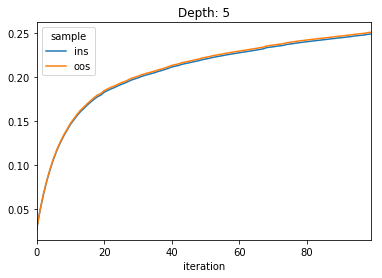

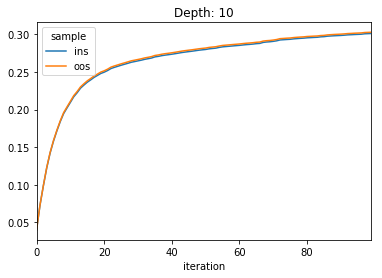

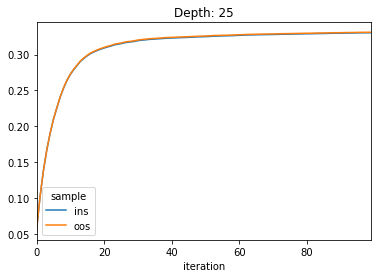

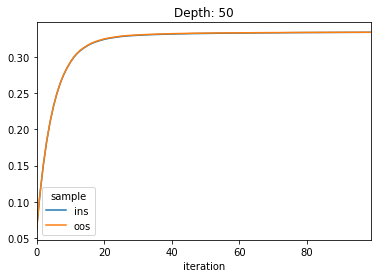

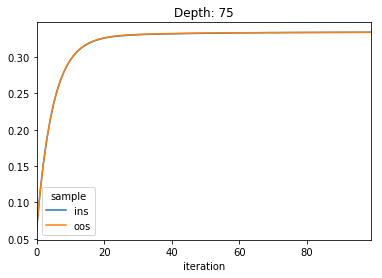

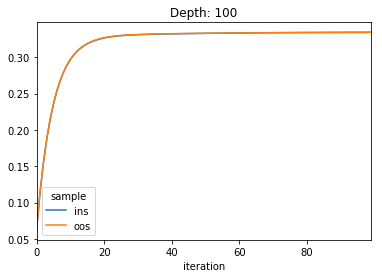

In [150]:
scores_df=pd.DataFrame(scores,columns=['depth','sample','iteration','r2'])
for depth in [5,10,25,50,75,100]:
    scores_df[scores_df['depth']==depth].groupby(['iteration','sample'])['r2'].sum().unstack().plot()
    plt.title('Depth: %d'%depth)
    plt.show()
    
    